:# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

## Задание 1

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [2]:
df = pd.read_csv('bikes_rent.csv')

df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

Постройте графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной **cnt**.

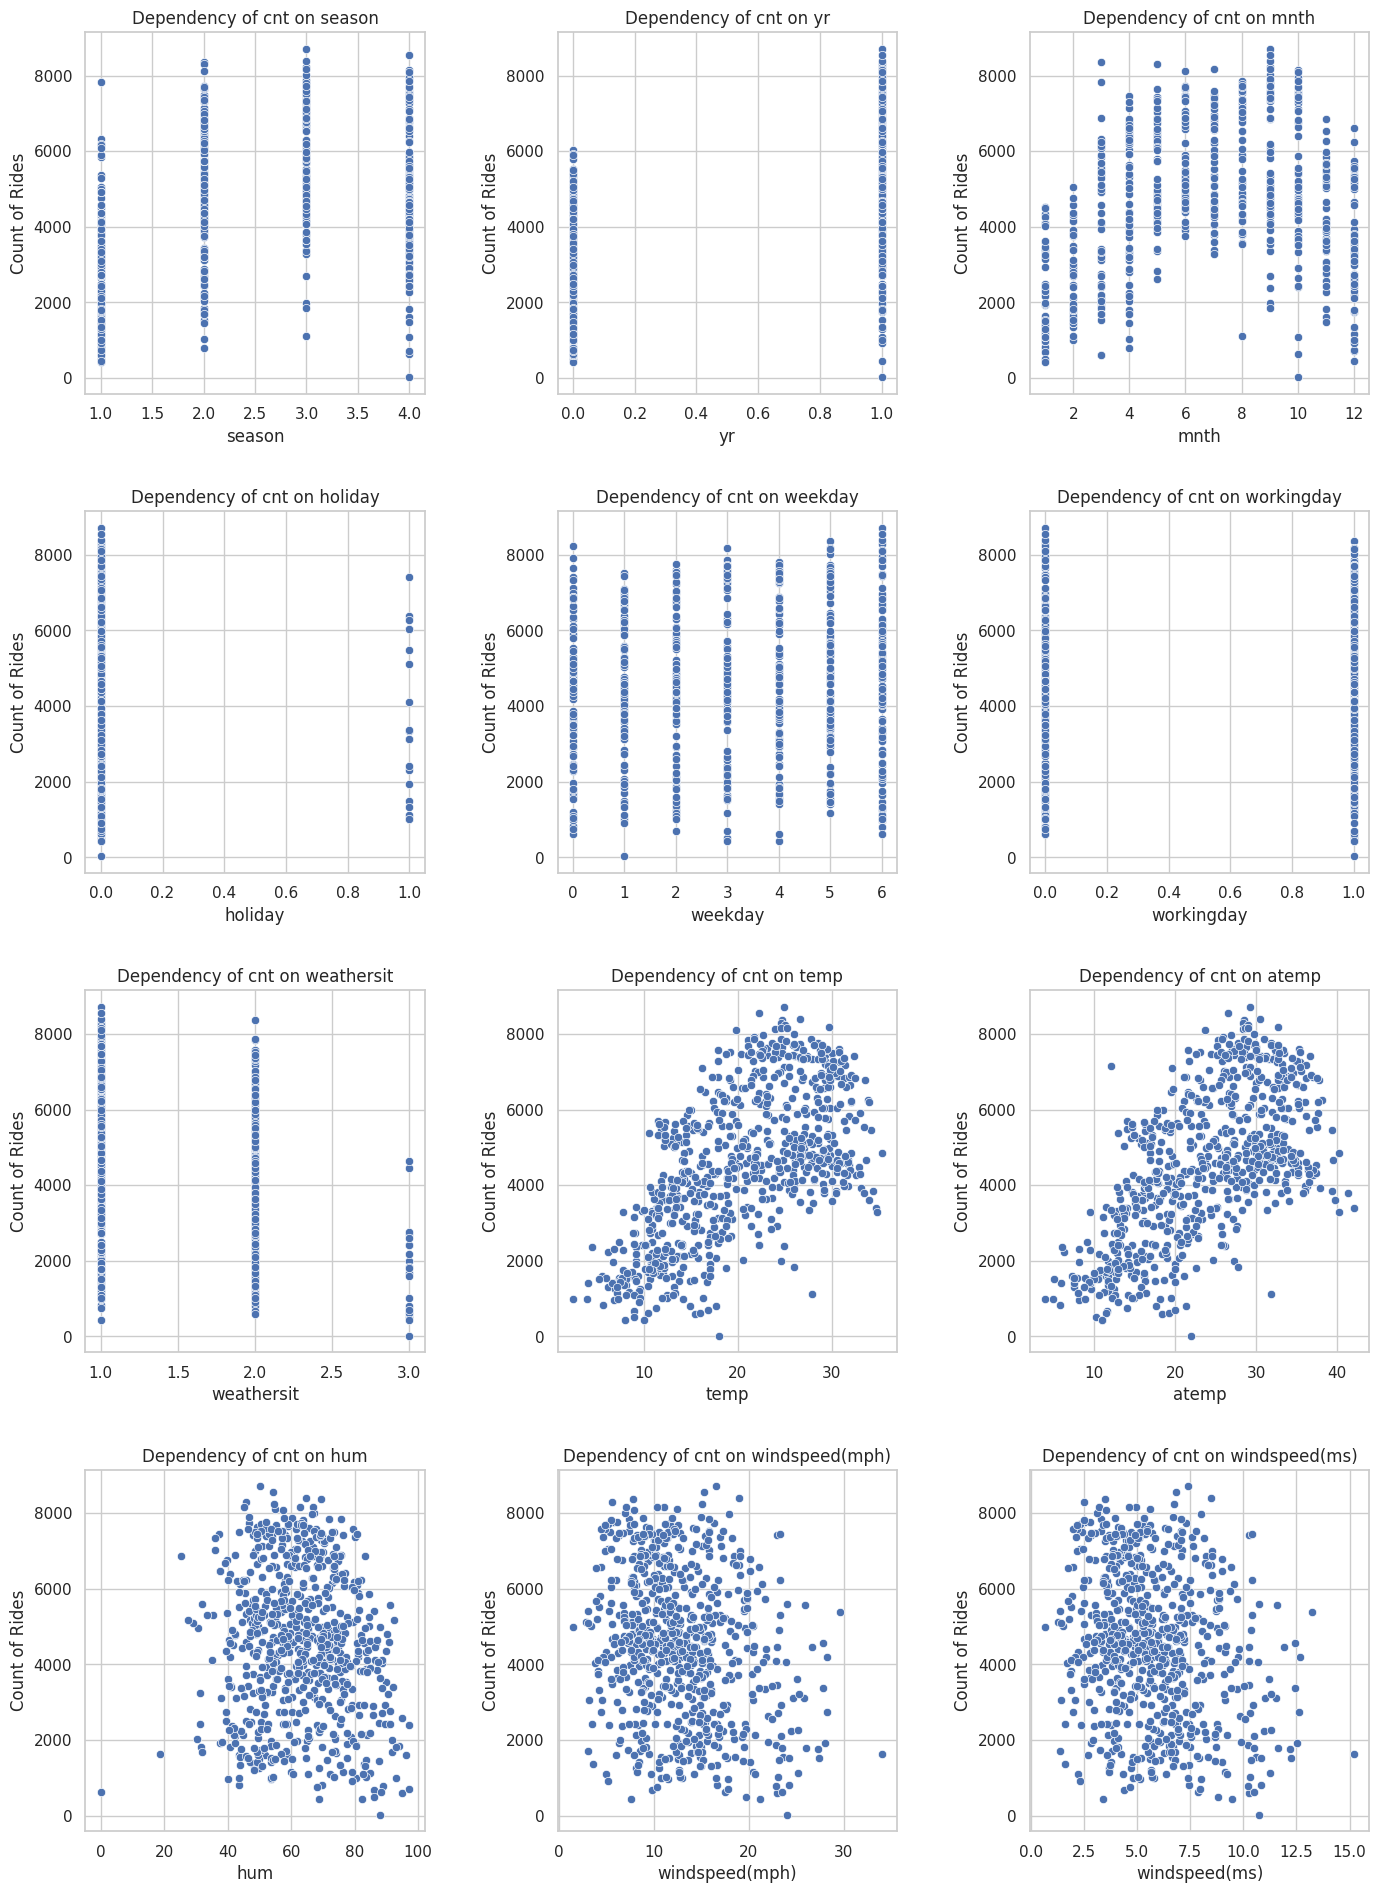

In [23]:
# візуал
sns.set(style="whitegrid")

# Список стовпців для побудови графіків проти 'cnt' (кількість поїздок)
columns_to_plot = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']

# Створюємо 12 графіків
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))
fig.tight_layout(pad=5.0) # Встановлення відступів між графіками

# Побудова графіків залежності 'cnt' від кожного признаку
for i, column in enumerate(columns_to_plot):
    row, col = i // 3, i % 3
    sns.scatterplot(x=df[column], y=df['cnt'], ax=axes[row, col])
    axes[row, col].set_title(f'Dependency of cnt on {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Count of Rides')

plt.show()


__Вопросы:__
1. Каков характер зависимости числа прокатов от месяца?

Відповідь:

- Залежність числа прокатів від місяця (атрибут mnth) є прямою (сезонною). Можна спостерігати збільшення кількості прокатів у теплі місяці та зменшення у холодніші місяці. Це може бути пов'язано з погодними умовами та зручністю використання велосипедів у різні періоди року.

2. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно?

Відповідь:

- Температура (temp): Можна побачити, що із
збільшенням температури кількість прокатів велосипедів також зростає.
- Відчувана температура (atemp): Цей признак, також має лінійну залежність, подібно до звичайної температури.


## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. Нам уже приходилось иметь с ней дело раньше. Для ее вычисления в pandas можно использовать методы датафрейма: corr и corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

In [5]:
# Розрахунок кореляції Пірсона між усіма атрибутами (крім останнього) і цільовою змінною 'cnt'
correlations = df.iloc[:, :-1].corrwith(df['cnt'])

correlations

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

## Задание 3

Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
с помощью метода corr:

In [24]:
selected_features = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']]
pairwise_correlations = selected_features.corr()

pairwise_correlations

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

## Задание 4

Выведите средние признаков

In [7]:
# Обчислення середніх значень для кожного атрибуту
feature_means = df.mean()

feature_means

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

**Признаки** имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему.

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [8]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [9]:
# Перемішування датасету
df_shuffled = shuffle(df, random_state=42)

# Масштабування признаків
X = scale(df_shuffled[df_shuffled.columns[:-1]])

# Вектор цільової змінної
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [10]:
from sklearn.linear_model import LinearRegression

## Задание 5

Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной `coef_` класса регрессора). Можно выводить пары (название признака, вес), воспользовавшись функцией `zip`, встроенной в язык python. Названия признаков хранятся в переменной `df.columns`.


In [11]:
# Створення та навчання лінійної регресії
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)

# Виведення ваг моделі
for feature, weight in zip(df.columns[:-1], linear_regressor.coef_):
    print(f"{feature}: {weight}")

season: 570.8637960129914
yr: 1021.9653779400622
mnth: -141.3017451148728
holiday: -86.7593446245368
weekday: 137.22506441350538
workingday: 56.391881775973005
weathersit: -330.2264620440312
temp: 367.48373260182126
atemp: 585.5493861188597
hum: -145.61430569885857
windspeed(mph): 12457138390688.885
windspeed(ms): -12457138390887.346


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой (temp, atemp) чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Для того, чтобы решить проблему мультиколлинеарности нужно воспользоваться регуляризатором. К оптимизируемому функционалу прибавляют $L_1$ или $L_2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

### Задание 6
Давайте попробуем обучить линейные модели с $L_1$ и $L_2$-регуляризацией, а далее сравним их веса. Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

Обучите линейную модель с $L_1$-регуляризацией (класс Lasso) и выведите веса

In [12]:
from sklearn.linear_model import Lasso

# Створення та навчання лінійної моделі з L1-регуляризацією (Lasso)
lasso_regressor = Lasso()
lasso_regressor.fit(X, y)

# Виведення ваг моделі Lasso
for feature, weight_lasso in zip(df.columns[:-1], lasso_regressor.coef_):
    print(f"{feature}: {weight_lasso}")

season: 560.2416160308861
yr: 1019.4634940657196
mnth: -128.73062703678696
holiday: -86.15278133371106
weekday: 137.34789390496314
workingday: 55.21237064135668
weathersit: -332.3698569623487
temp: 376.3632362096943
atemp: 576.530793504555
hum: -144.12915500348583
windspeed(mph): -197.1396894024843
windspeed(ms): -2.8051404183533485e-08


Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [13]:
from sklearn.linear_model import Ridge

# Створення та навчання лінійної моделі з L2-регуляризацією (Ridge)
ridge_regressor = Ridge()
ridge_regressor.fit(X, y)

# Виведення ваг моделі Ridge
for feature, weight_ridge in zip(df.columns[:-1], ridge_regressor.coef_):
  print(f"{feature}: {weight_ridge}")

season: 563.0645722520181
yr: 1018.9483787875305
mnth: -131.87332028247715
holiday: -86.74609799709232
weekday: 138.00511117871918
workingday: 55.90311037506467
weathersit: -332.34978849907367
temp: 386.45788919190807
atemp: 566.3470470600669
hum: -145.07132729867195
windspeed(mph): -99.25944108179067
windspeed(ms): -99.25944115434177


### Задание 7

В отличие от $L_2$-регуляризации, $L_1$ обнуляет веса при некоторых признаках Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

Для каждого значения коэффициента из `alphas` обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список`coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [14]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    # Lasso
    lasso = Lasso(alpha)
    lasso.fit(X, y)
    coefs_lasso.append(lasso.coef_)

    # Ridge
    ridge = Ridge(alpha)
    ridge.fit(X, y)
    coefs_ridge.append(ridge.coef_)

# Конвертація списків в numpy arrays
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

# Виведення перших кількох значень для перевірки
print(f'Ваги при використанні L1 -регуляризации: \n{coefs_lasso[:1]}')
print()
print(f'Ваги при використанні L2 -регуляризации: \n{coefs_ridge[:1]}')
# coefs_lasso[:1], coefs_ridge[:1]

Ваги при використанні L1 -регуляризации: 
[[ 5.60241616e+02  1.01946349e+03 -1.28730627e+02 -8.61527813e+01
   1.37347894e+02  5.52123706e+01 -3.32369857e+02  3.76363236e+02
   5.76530794e+02 -1.44129155e+02 -1.97139689e+02 -2.80514042e-08]]

Ваги при використанні L2 -регуляризации: 
[[ 563.06457225 1018.94837879 -131.87332028  -86.746098    138.00511118
    55.90311038 -332.3497885   386.45788919  566.34704706 -145.0713273
   -99.25944108  -99.25944115]]


Проанализируйте динамику весов при увеличении параметра регуляризации:

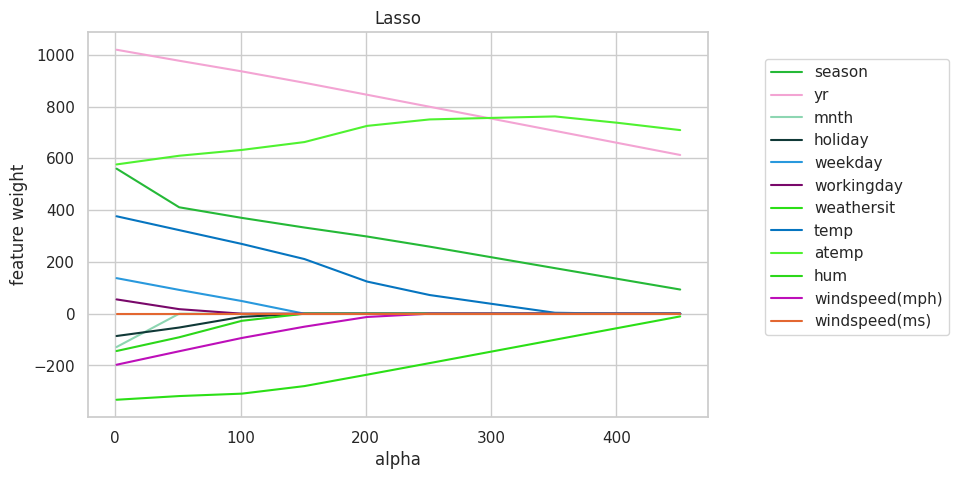

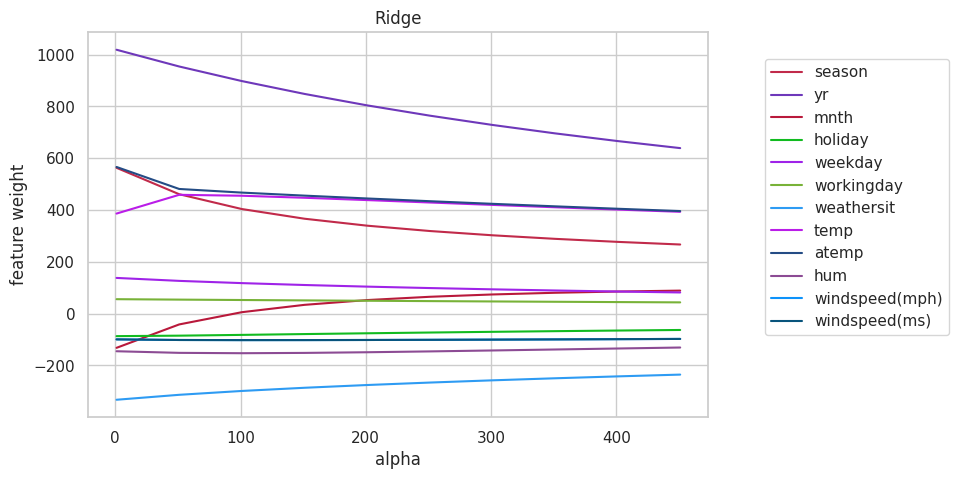

In [15]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проанализируйте графики и дайте ответы на следующие вопросы.

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?

Відповідь:

- Lasso (L1-регуляризація) має тенденцію до більш агресивного зменшення ваг, включаючи обнулення ваг деяких атрибутів. Це видно з того, як деякі лінії на графіку Lasso швидко спадають до нуля, особливо при збільшенні alpha.
Ridge (L2-регуляризація), навпаки, зменшує ваги більш плавно і рівномірно, не призводячи до їх повного обнулення. На графіку Ridge лінії залишаються відносно стабільними або зменшуються плавно зі зростанням alpha.
Таким чином, Lasso є більш агресивним у зменшенні ваг при однакових значеннях alpha порівняно з Ridge.

2. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.

Відповідь:

- Якщо значення alpha у Lasso регуляризації стане дуже великим, то ваги багатьох атрибутів зменшаться до нуля. Це відбувається, тому що Lasso накладає штрафи на модель за великі ваги. Чим вище alpha, тим більші штрафи, і щоб уникнути цих штрафів, модель "вирішує", що краще зробити більшість ваг якомога меншими, навіть нульовими. В результаті модель ігнорує багато атрибутів, що може призвести до втрати важливої інформації.

3. Можно ли утверждать, что `Lasso` исключает один из признаков `windspeed` при любом значении `alpha > 0`? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем меньше $10^{-3}$.

Відповідь:

- У нашому випадку один з признаків windspeed дійсно був виключений (обнулений) Lasso при alpha > 0, оскільки вага одного з них була близька або дорівнювала нулю, тоді як Ridge цього не зробив.

4. Какой из регуляризаторов подойдет для отбора неинформативных признаков?

Відповідь:

- Lasso (L1-регуляризація)

### Задание 8

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ часте, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку.

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

Обучите регрессор `LassoCV` на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам `MSE` в зависимости от `alpha` (используйте для этого функцию `create_plot`).

Выведите выбранное `alpha`, а также пары "признак-коэффициент" для обученного вектора коэффициентов.

In [16]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

Alpha = 6
season: 532.0189828413535
yr: 1015.0602226430595
mnth: -100.03952614356629
holiday: -83.29395987529904
weekday: 132.50446549095795
workingday: 51.557085614073735
weathersit: -330.5598567399817
temp: 370.67985503003405
atemp: 581.396931065498
hum: -140.00740550068844
windspeed(mph): -191.77140847135036
windspeed(ms): -2.6854702314758792e-08


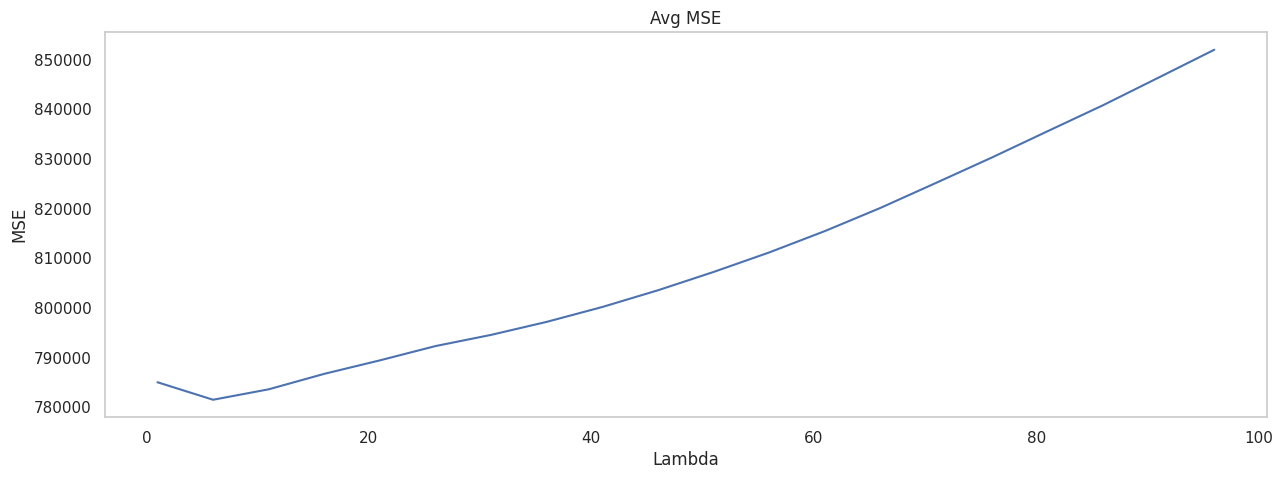

In [19]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=3)
regressor.fit(X, y)
#print (f'Матрица змінної mse_path_: \n{regressor.mse_path_}')

# Підготовка даних для графіку
mse_mean = regressor.mse_path_.mean(axis=1)
data_for_plot = list(zip(regressor.alphas_, mse_mean))

# Виведення вибраного alpha
selected_alpha = regressor.alpha_
print(f"Alpha = {selected_alpha}")

# Виведення пар "признак-коефіцієнт"
feature_weights = zip(df.columns[:-1], regressor.coef_)
print("\n".join([f"{feature}: {weight}" for feature, weight in feature_weights]))

# Побудова графіку
create_plot(data_for_plot, "Avg MSE", "Lambda", "MSE")

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

### Задание 9

Выведите значения `alpha`, соответствующие минимумам `MSE` на каждом разбиении (то есть по столбцам).
На трех отдельных графиках визуализируйте столбцы `mse_path_`.


Alphas with minimum MSE:
Alpha = 6, MSE = 733725.7604052249
Alpha = 1, MSE = 799433.1673691692
Alpha = 51, MSE = 796979.8955193626


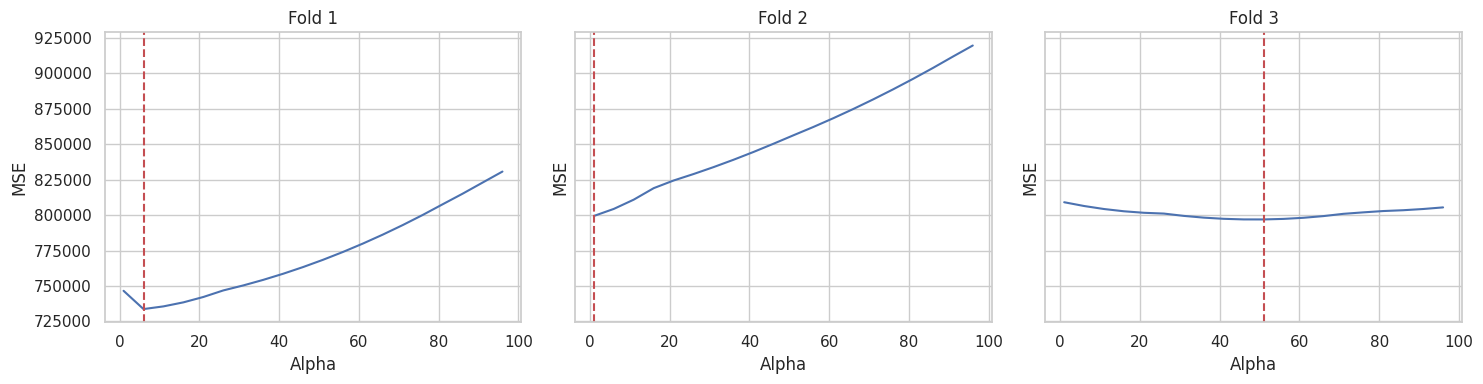

In [30]:
# Виведення значень alpha, які відповідають мінімумам MSE на кожному розбитті
min_mse_indices = regressor.mse_path_.argmin(axis=0)
min_mse_alphas = regressor.alphas_[min_mse_indices]
min_mse_values = regressor.mse_path_.min(axis=0)

# Виведення результатів
print("Alphas with minimum MSE:")
for i in range(len(min_mse_alphas)):
    print(f"Alpha = {min_mse_alphas[i]}, MSE = {min_mse_values[i]}")

# Візуалізація стовпців mse_path_ на трьох окремих графіках
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for i in range(3):
    axes[i].plot(regressor.alphas_, regressor.mse_path_[:, i])
    axes[i].set_title(f"Fold {i+1}")
    axes[i].set_xlabel('Alpha')
    axes[i].set_ylabel('MSE')
    axes[i].axvline(x=min_mse_alphas[i], color='r', linestyle='--')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки.

### Задание 10

Наконец, как принято в анализе данных, давайте проинтерпретируем результат. Ответьте на следующие вопросы.

#### Вопрос 1

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей `cnt` от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды?

__Ответ:__

In [ ]:
# Виберемо 4 признаки з найбільшими позитивними вагами
feature_weights = sorted(zip(df.columns[:-1], regressor.coef_), key=lambda x: x[1], reverse=True)
top_features = feature_weights[:4]
top_features_output = "\n".join([f"{feature}: {weight:.2f}" for feature, weight in top_features])
print(f'4 признаки з найбільшими позитивними вагами:\n{top_features_output}')

4 признаки з найбільшими позитивними вагами:
yr: 1015.06
atemp: 581.40
season: 532.02
temp: 370.68


Відповідь:

- yr (рік): Позитивний коефіцієнт може вказувати на зростання кількості оренд
велосипедів із року в рік, що може бути пов'язано зі збільшенням популярності сервісу, поліпшенням умов або зростанням кількості велосипедних доріжок.

- atemp (відчувана температура): З візуалізації можна було побачити, що зі збільшенням відчуваної температури кількість оренд велосипедів зростає, що логічно, оскільки краще кататися на велосипеді в комфортну погоду.

- season (сезон): Зазвичай, у теплі сезони, такі як весна та літо, оренда велосипедів зростає, оскільки погодні умови більш сприятливі для велопрогулянок.

- temp (температура): Подібно до atemp, зростання температури зазвичай сприяє збільшенню кількості оренд велосипедів.

На основі цих даних та графіків, які ми раніше розглядали, можна стверджувати, що існує візуально помітна позитивна залежність між cnt і вищеназваними признаками. І так, зі здравого смислу, логічно припустити, що зі збільшенням значення цих признаків кількість людей, які хочуть взяти велосипеди в оренду, збільшується.

#### Вопрос 2

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

__Ответ:__

In [ ]:
# Виберемо 3 признаки з найбільшими за модулем негативними вагами
negative_feature_weights = sorted(zip(df.columns[:-1], regressor.coef_), key=lambda x: x[1])
top_negative_features = negative_feature_weights[:3]

# Формування виводу для трьох признаків з найбільшими негативними вагами
top_negative_features_output = "\n".join([f"{feature}: {weight:.2f}" for feature, weight in top_negative_features])
print(f'3 признаки з найбільшими за модулем негативними вагами:\n{top_negative_features_output}')

3 признаки з найбільшими за модулем негативними вагами:
weathersit: -330.56
windspeed(mph): -191.77
hum: -140.01


Відповідь:
- weathersit (погодні умови): Від'ємний коефіцієнт вказує на те, що з погіршенням погодних умов (зростанням значення weathersit) кількість оренд велосипедів зменшується. Це логічно, оскільки користуватися велосипедами в негоду не дуже комфортно.

- windspeed(mph) (швидкість вітру): Аналогічно, збільшення швидкості вітру може зменшувати комфорт їзди на велосипеді, відповідно зменшуючи кількість оренд.

- hum (вологість): Висока вологість може бути пов'язана з менш комфортними умовами для їзди на велосипеді, що також може призводити до зниження кількості оренд.

На графіках, які ми аналізували раніше, ми можемо спостерігати зменшення кількості оренд велосипедів зі збільшенням цих признаків. Тому можна логічно припустити, що зі збільшенням величини цих признаків, менше людей захоче брати велосипеди в оренду. ​

#### Вопрос 3

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

__Ответ:__

In [ ]:
# Признаки з коэфіцієнтами, близькими до нулю (< 1e-3)
near_zero_features = [(feature, weight) for feature, weight in zip(df.columns[:-1], regressor.coef_) if abs(weight) < 1e-3]

# Вивід признаків з коэфіцієнтами, близькими до нулю
near_zero_features_output = "\n".join([f"{feature}: {weight:.10f}" for feature, weight in near_zero_features])
print(f'Признаки з коэфіцієнтами, близькими к нулю (< 1e-3):\n{near_zero_features_output}')

Признаки з коэфіцієнтами, близькими к нулю (< 1e-3):
windspeed(ms): -0.0000000269


Відповідь:

- windspeed(ms) (швидкість вітру в метрах за секунду): Цей признак є альтернативним представленням windspeed(mph) і, як такий, є повністю корельованим з ним. Оскільки Lasso регуляризація схильна обнуляти ваги корельованих признаків, одна з цих двох швидкостей вітру буде мати коэфіцієнт, близький до нуля. Це відображає факт, що наявність обох цих признаків у моделі є зайвою, і Lasso вибирає лише один із них для включення в модель.

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации.

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель. Такой процесс занимает много времени, особенно если нужно обучаться на больших объемах данных.